# AutoML for wage prediction

## Automatic Machine Learning with H2O AutoML using Wage Data from 2015

We illustrate how to predict an outcome variable Y in a high-dimensional setting, using the AutoML package *H2O* that covers the complete pipeline from the raw dataset to the deployable machine learning model. In last few years, AutoML or automated machine learning has become widely popular among data science community. 

We can use AutoML as a benchmark and compare it to the methods that we used in the previous notebook where we applied one machine learning method after the other.

In [10]:
# Import relevant packages
import pandas as pd
import numpy as np
import pyreadr
import os
from urllib.request import urlopen
from sklearn import preprocessing
import patsy
from h2o.automl import H2OAutoML

from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
import warnings
warnings.filterwarnings('ignore')

In [2]:
#pip install h2o

In [11]:
# load the H2O package
import h2o

# start h2o cluster
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,4 hours 11 mins
H2O_cluster_timezone:,America/Bogota
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.3
H2O_cluster_version_age:,26 days
H2O_cluster_name:,H2O_from_python_User_fi8ht0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.467 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [12]:
link="https://raw.githubusercontent.com/d2cml-ai/14.388_py/main/data/wage2015_subsample_inference.Rdata"
response = urlopen(link)
content = response.read()
fhandle = open( 'wage2015_subsample_inference.Rdata', 'wb')
fhandle.write(content)
fhandle.close()
result = pyreadr.read_r("wage2015_subsample_inference.Rdata")
os.remove("wage2015_subsample_inference.Rdata")

# Extracting the data frame from rdata_read
data = result[ 'data' ]
n = data.shape[0]
type(data)

pandas.core.frame.DataFrame

In [13]:
# Import relevant packages for splitting data
import random
import math

# Set Seed
# to make the results replicable (generating random numbers)
np.random.seed(0)
random = np.random.randint(0, data.shape[0], size=math.floor(data.shape[0]))
data["random"] = random
random    # the array does not change 
data_2 = data.sort_values(by=['random'])

In [14]:
# Create training and testing sample 
train = data_2[ : math.floor(n*3/4)]    # training sample
test =  data_2[ math.floor(n*3/4) : ]   # testing sample
print(train.shape)
print(test.shape)

(3862, 21)
(1288, 21)


In [15]:
# start h2o cluster
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,4 hours 12 mins
H2O_cluster_timezone:,America/Bogota
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.3
H2O_cluster_version_age:,26 days
H2O_cluster_name:,H2O_from_python_User_fi8ht0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.467 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [16]:
# convert data as h2o type
train_h = h2o.H2OFrame(train)
test_h = h2o.H2OFrame(test)

# have a look at the data
train_h.describe()


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Rows:3862
Cols:21




,wage,lwage,sex,shs,hsg,scl,clg,ad,mw,so,we,ne,exp1,exp2,exp3,exp4,occ,occ2,ind,ind2,random
type,real,real,int,int,int,int,int,int,int,int,int,int,real,real,real,real,int,int,int,int,int
mins,3.021978021978022,1.1059115911497213,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,1.0,370.0,2.0,0.0
mean,23.465417731467202,2.969427791239379,0.446918694976696,0.023562920766442258,0.24702226825479026,0.2780942516830658,0.3125323666494045,0.13878819264629724,0.2553081305023304,0.29829104091144487,0.21569135163127914,0.23070947695494562,13.672190574831728,2.9923032107716137,8.15417316157433,24.849760334671146,5243.418436043504,11.69135163127914,6667.996116002073,13.333764888658706,1914.2263076126374
maxs,528.845673076923,6.270696655981913,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,47.0,22.09,103.823,487.9681,100000.0,22.0,100000.0,22.0,3825.0
sigma,21.430085743506766,0.5750893708933925,0.4972387709704293,0.15170256601034887,0.4313356487428773,0.44811810407097313,0.46358551980855045,0.3457701367976389,0.436090737870262,0.45756716236312467,0.4113543571812672,0.4213414081729523,10.598613687032655,3.987480265404191,14.424744487903597,53.27996156215637,11579.91114662104,6.9783416585657125,5588.264282354911,5.691380293915183,1104.7025392074318
zeros,0,0,2136,3771,2908,2788,2655,3326,2876,2710,3029,2971,48,48,48,48,0,0,0,0,3
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,26.442307692307693,3.274965291519244,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,29.0,8.41,24.389,70.7281,340.0,1.0,8660.0,20.0,0.0
1,19.23076923076923,2.9565115604007097,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,33.5,11.2225,37.595375,125.94450625,9620.0,22.0,1870.0,5.0,0.0
2,48.07692307692308,3.872802292274865,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.04,0.008,0.0016,3060.0,10.0,8190.0,18.0,0.0


In [17]:
# define the variables
y = 'lwage'

data_columns = list(data)
no_relev_col = ['wage','occ2', 'ind2', 'random', 'lwage']

# This gives us: new_list = ['carrot' , 'lemon']
x = [col for col in data_columns if col not in no_relev_col]


In [18]:
# run AutoML for 10 base models and a maximal runtime of 100 seconds
# Run AutoML for 30 seconds
aml = H2OAutoML(max_runtime_secs = 100, max_models = 10, seed = 1)
aml.train(x = x, y = y, training_frame = train_h, leaderboard_frame = test_h)


AutoML progress: |█
05:14:21.267: AutoML: XGBoost is not available; skipping it.

██████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_1_AutoML_2_20220804_51421

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.14963411645818037
RMSE: 0.38682569260350375
MAE: 0.29493414661545647
RMSLE: 0.09962964024727533
R^2: 0.5474439172253015
Mean Residual Deviance: 0.14963411645818037
Null degrees of freedom: 3861
Residual degrees of freedom: 3855
Null deviance: 1276.9399854672324
Residual deviance: 577.8869577614926
AIC: 3639.772059449712

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.21847845950742845
RMSE: 0.4674167942077268
MAE: 0.35554195972164104
RMSLE: 0.11935352477830528
R^2: 0.3392298618411601
Mean Residual Deviance: 0.21847845950742845
Null degrees of freedom

,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,0.355537,0.011149,0.358856,0.365665,0.336852,0.354934,0.361377
1,mean_residual_deviance,0.218658,0.018164,0.232228,0.226281,0.191559,0.208852,0.234372
2,mse,0.218658,0.018164,0.232228,0.226281,0.191559,0.208852,0.234372
3,null_deviance,255.420870,18.944805,270.143950,279.337650,235.192600,252.053120,240.377060
4,r2,0.339152,0.024681,0.332046,0.342915,0.367003,0.352354,0.301443
5,residual_deviance,168.744060,13.997013,180.441440,183.513900,148.841520,163.113280,167.810170
6,rmse,0.467278,0.019686,0.481901,0.475690,0.437675,0.457003,0.484120
7,rmsle,0.119307,0.004619,0.122457,0.121297,0.111312,0.119422,0.122048


In [22]:
# AutoML Leaderboard
lb = aml.leaderboard
print(lb)

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_1_20220722_170939,0.47064,0.221502,0.353943,0.120368,0.221502
GBM_2_AutoML_1_20220722_170939,0.471849,0.222642,0.355941,0.12074,0.222642
GBM_5_AutoML_1_20220722_170939,0.47191,0.222699,0.35582,0.120501,0.222699
StackedEnsemble_BestOfFamily_1_AutoML_1_20220722_170939,0.473798,0.224484,0.357598,0.121491,0.224484
GBM_3_AutoML_1_20220722_170939,0.474585,0.22523,0.359309,0.121264,0.22523
GBM_1_AutoML_1_20220722_170939,0.478149,0.228626,0.362211,0.122278,0.228626
GBM_4_AutoML_1_20220722_170939,0.479072,0.22951,0.362916,0.122456,0.22951
GBM_grid_1_AutoML_1_20220722_170939_model_1,0.48001,0.23041,0.36381,0.122671,0.23041
XRT_1_AutoML_1_20220722_170939,0.491218,0.241295,0.375089,0.125318,0.241295
DRF_1_AutoML_1_20220722_170939,0.50224,0.252245,0.382606,0.12847,0.252245


We see that two Stacked Ensembles are at the top of the leaderboard. Stacked Ensembles often outperform a single model. The out-of-sample (test) MSE of the leading model is given by

In [23]:
aml.leaderboard['mse'][0,0]

0.22150159010610537

The in-sample performance can be evaluated by

In [24]:
aml.leader

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_1_AutoML_1_20220722_170939

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.15027004489538795
RMSE: 0.38764680431468534
MAE: 0.2955371675604367
RMSLE: 0.09990016533775842
R^2: 0.5455206039510314
Mean Residual Deviance: 0.15027004489538795
Null degrees of freedom: 3861
Residual degrees of freedom: 3854
Null deviance: 1276.9399854672324
Residual deviance: 580.3429133859883
AIC: 3658.1503537307485

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.2185070080606413
RMSE: 0.46744733185744175
MAE: 0.35554501482828577
RMSLE: 0.11935774800872184
R^2: 0.3391435190891413
Mean Residual Deviance: 0.2185070080606413
Null degrees of freedom: 3861
Residual degrees of freedom: 3853
Null deviance: 1277.1043650451534
Residual deviance: 843.8740651301968
AIC: 5106.021797066896

Cross-Validation Metri

,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,0.355575,0.011150,0.358694,0.365597,0.336775,0.355430,0.361377
1,mean_residual_deviance,0.218685,0.018149,0.232207,0.226213,0.191451,0.209182,0.234372
2,mse,0.218685,0.018149,0.232207,0.226213,0.191451,0.209182,0.234372
3,null_deviance,255.420870,18.944805,270.143950,279.337650,235.192600,252.053120,240.377060
4,r2,0.339071,0.024654,0.332108,0.343113,0.367360,0.351331,0.301443
5,residual_deviance,168.764340,13.983558,180.424550,183.458680,148.757460,163.370830,167.810170
6,rmse,0.467306,0.019674,0.481878,0.475618,0.437551,0.457364,0.484120
7,rmsle,0.119310,0.004632,0.122437,0.121279,0.111271,0.119514,0.122048


This is in line with our previous results. To understand how the ensemble works, let's take a peek inside the Stacked Ensemble "All Models" model.  The "All Models" ensemble is an ensemble of all of the individual models in the AutoML run.  This is often the top performing model on the leaderboard.

In [25]:
model_ids = h2o.as_list(aml.leaderboard['model_id'][0], use_pandas=True)


In [26]:
model = model_ids[model_ids['model_id'].str.contains("StackedEnsemble_AllModels")].values.tolist()
model_id = model[0][0]
model_id

'StackedEnsemble_AllModels_1_AutoML_1_20220722_170939'

In [30]:
se = h2o.get_model(model_id)
se

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_1_AutoML_1_20220722_170939

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.15027004489538795
RMSE: 0.38764680431468534
MAE: 0.2955371675604367
RMSLE: 0.09990016533775842
R^2: 0.5455206039510314
Mean Residual Deviance: 0.15027004489538795
Null degrees of freedom: 3861
Residual degrees of freedom: 3854
Null deviance: 1276.9399854672324
Residual deviance: 580.3429133859883
AIC: 3658.1503537307485

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.2185070080606413
RMSE: 0.46744733185744175
MAE: 0.35554501482828577
RMSLE: 0.11935774800872184
R^2: 0.3391435190891413
Mean Residual Deviance: 0.2185070080606413
Null degrees of freedom: 3861
Residual degrees of freedom: 3853
Null deviance: 1277.1043650451534
Residual deviance: 843.8740651301968
AIC: 5106.021797066896

Cross-Validation Metri

,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,0.355575,0.011150,0.358694,0.365597,0.336775,0.355430,0.361377
1,mean_residual_deviance,0.218685,0.018149,0.232207,0.226213,0.191451,0.209182,0.234372
2,mse,0.218685,0.018149,0.232207,0.226213,0.191451,0.209182,0.234372
3,null_deviance,255.420870,18.944805,270.143950,279.337650,235.192600,252.053120,240.377060
4,r2,0.339071,0.024654,0.332108,0.343113,0.367360,0.351331,0.301443
5,residual_deviance,168.764340,13.983558,180.424550,183.458680,148.757460,163.370830,167.810170
6,rmse,0.467306,0.019674,0.481878,0.475618,0.437551,0.457364,0.484120
7,rmsle,0.119310,0.004632,0.122437,0.121279,0.111271,0.119514,0.122048


In [31]:
# Get the Stacked Ensemble metalearner model
metalearner = se.metalearner()
metalearner

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  metalearner_AUTO_StackedEnsemble_AllModels_1_AutoML_1_20220722_170939


GLM Model: summary


,,family,link,regularization,lambda_search,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,gaussian,identity,"Elastic Net (alpha = 0.5, lambda = 0.002551 )","nlambda = 100, lambda.max = 0.2219, lambda.min = 0.002551, lambda....",10,7,49,levelone_training_StackedEnsemble_AllModels_1_AutoML_1_20220722_17...




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.21727419974117612
RMSE: 0.4661268065035266
MAE: 0.35448759076481845
RMSLE: 0.11902010738109643
R^2: 0.3428720464937892
Mean Residual Deviance: 0.21727419974117612
Null degrees of freedom: 3861
Residual degrees of freedom: 3854
Null deviance: 1276.9399854672324
Residual deviance: 839.1129594004221
AIC: 5082.170839083037

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 0.2185070080606413
RMSE: 0.46744733185744175
MAE: 0.35554501482828577
RMSLE: 0.11935774800872184
R^2: 0.3391435190891413
Mean Residual Deviance: 0.2185070080606413
Null degrees of freedom: 3861
Residual degrees of freedom: 3853
Null deviance: 1277.1043650451534
Residual deviance: 843.8740651301968
AIC: 5106.021797066896

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,0.355575,0.011150,0.358694,0.365597,0.336775,0.355430,0.361377
1,mean_residual_deviance,0.218685,0.018149,0.232207,0.226213,0.191451,0.209182,0.234372
2,mse,0.218685,0.018149,0.232207,0.226213,0.191451,0.209182,0.234372
3,null_deviance,255.420870,18.944805,270.143950,279.337650,235.192600,252.053120,240.377060
4,r2,0.339071,0.024654,0.332108,0.343113,0.367360,0.351331,0.301443
5,residual_deviance,168.764340,13.983558,180.424550,183.458680,148.757460,163.370830,167.810170
6,rmse,0.467306,0.019674,0.481878,0.475618,0.437551,0.457364,0.484120
7,rmsle,0.119310,0.004632,0.122437,0.121279,0.111271,0.119514,0.122048



Scoring History: 


,,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_xval,deviance_se,alpha,iterations,training_rmse,training_deviance,training_mae,training_r2
0,,2022-07-22 17:10:18,0.000 sec,1,",22E0",1,0.330642,0.330652,0.008216,0.5,NaN,,,,
1,,2022-07-22 17:10:18,0.000 sec,2,",2E0",5,0.316066,0.330609,0.008220,0.5,NaN,,,,
2,,2022-07-22 17:10:18,0.000 sec,3,",18E0",6,0.302049,0.330627,0.008216,0.5,NaN,,,,
3,,2022-07-22 17:10:18,0.000 sec,4,",17E0",6,0.289848,0.322157,0.008512,0.5,NaN,,,,
4,,2022-07-22 17:10:18,0.016 sec,5,",15E0",7,0.279287,0.307694,0.008407,0.5,5.0,0.528476,0.279287,0.407732,0.155318
5,,2022-07-22 17:10:18,0.016 sec,6,",14E0",7,0.270007,0.294801,0.008323,0.5,NaN,,,,
6,,2022-07-22 17:10:18,0.016 sec,7,",13E0",7,0.262086,0.283621,0.008253,0.5,NaN,,,,
7,,2022-07-22 17:10:18,0.016 sec,8,",12E0",7,0.255335,0.273875,0.008226,0.5,NaN,,,,
8,,2022-07-22 17:10:18,0.016 sec,9,",11E0",8,0.249586,0.265471,0.008206,0.5,NaN,,,,
9,,2022-07-22 17:10:18,0.016 sec,10,",96E-1",8,0.244598,0.258304,0.008188,0.5,10.0,0.494568,0.244598,0.377588,0.260234



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,GBM_5_AutoML_1_20220722_170939,0.156444,1.000000,0.459637
1,GBM_3_AutoML_1_20220722_170939,0.064177,0.410220,0.188552
2,GBM_1_AutoML_1_20220722_170939,0.045077,0.288132,0.132436
3,GBM_grid_1_AutoML_1_20220722_170939_model_1,0.042987,0.274777,0.126298
4,GBM_4_AutoML_1_20220722_170939,0.022251,0.142227,0.065373
5,DeepLearning_1_AutoML_1_20220722_170939,0.009429,0.060268,0.027701
6,DRF_1_AutoML_1_20220722_170939,0.000001,0.000007,0.000003
7,GBM_2_AutoML_1_20220722_170939,0.000000,0.000000,0.000000
8,XRT_1_AutoML_1_20220722_170939,0.000000,0.000000,0.000000
9,GLM_1_AutoML_1_20220722_170939,0.000000,0.000000,0.000000


Examine the variable importance of the metalearner (combiner) algorithm in the ensemble. This shows us how much each base learner is contributing to the ensemble. The AutoML Stacked Ensembles use the default metalearner algorithm (GLM with non-negative weights), so the variable importance of the metalearner is actually the standardized coefficient magnitudes of the GLM.

The table above gives us the variable importance of the metalearner in the ensemble. The AutoML Stacked Ensembles use the default metalearner algorithm (GLM with non-negative weights), so the variable importance of the metalearner is actually the standardized coefficient magnitudes of the GLM. 


In [32]:
metalearner.coef_norm()

{'Intercept': 2.969427791239395,
 'GBM_2_AutoML_1_20220722_170939': 0.0,
 'GBM_5_AutoML_1_20220722_170939': 0.1564442116943833,
 'GBM_3_AutoML_1_20220722_170939': 0.06417658529927933,
 'GBM_1_AutoML_1_20220722_170939': 0.04507655475235933,
 'GBM_4_AutoML_1_20220722_170939': 0.02225052417703666,
 'GBM_grid_1_AutoML_1_20220722_170939_model_1': 0.0429872925804153,
 'XRT_1_AutoML_1_20220722_170939': 0.0,
 'DRF_1_AutoML_1_20220722_170939': 1.1143189727895769e-06,
 'GLM_1_AutoML_1_20220722_170939': 0.0,
 'DeepLearning_1_AutoML_1_20220722_170939': 0.009428554928469175}

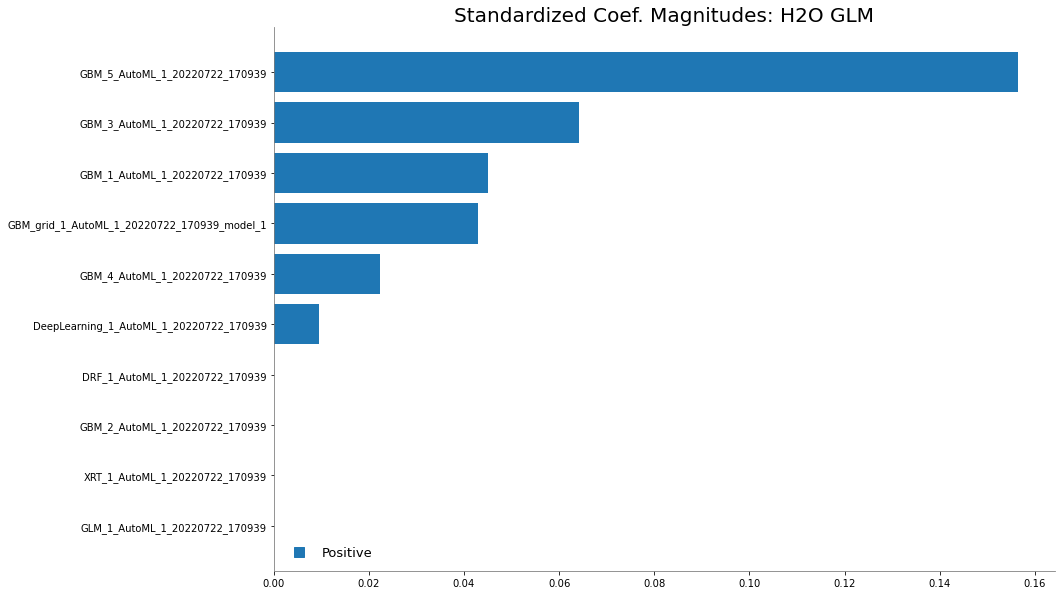

In [33]:
metalearner.std_coef_plot()

In [34]:
h2o.get_model(model_id).metalearner()

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  metalearner_AUTO_StackedEnsemble_AllModels_1_AutoML_1_20220722_170939


GLM Model: summary


,,family,link,regularization,lambda_search,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,gaussian,identity,"Elastic Net (alpha = 0.5, lambda = 0.002551 )","nlambda = 100, lambda.max = 0.2219, lambda.min = 0.002551, lambda....",10,7,49,levelone_training_StackedEnsemble_AllModels_1_AutoML_1_20220722_17...




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.21727419974117612
RMSE: 0.4661268065035266
MAE: 0.35448759076481845
RMSLE: 0.11902010738109643
R^2: 0.3428720464937892
Mean Residual Deviance: 0.21727419974117612
Null degrees of freedom: 3861
Residual degrees of freedom: 3854
Null deviance: 1276.9399854672324
Residual deviance: 839.1129594004221
AIC: 5082.170839083037

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 0.2185070080606413
RMSE: 0.46744733185744175
MAE: 0.35554501482828577
RMSLE: 0.11935774800872184
R^2: 0.3391435190891413
Mean Residual Deviance: 0.2185070080606413
Null degrees of freedom: 3861
Residual degrees of freedom: 3853
Null deviance: 1277.1043650451534
Residual deviance: 843.8740651301968
AIC: 5106.021797066896

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,0.355575,0.011150,0.358694,0.365597,0.336775,0.355430,0.361377
1,mean_residual_deviance,0.218685,0.018149,0.232207,0.226213,0.191451,0.209182,0.234372
2,mse,0.218685,0.018149,0.232207,0.226213,0.191451,0.209182,0.234372
3,null_deviance,255.420870,18.944805,270.143950,279.337650,235.192600,252.053120,240.377060
4,r2,0.339071,0.024654,0.332108,0.343113,0.367360,0.351331,0.301443
5,residual_deviance,168.764340,13.983558,180.424550,183.458680,148.757460,163.370830,167.810170
6,rmse,0.467306,0.019674,0.481878,0.475618,0.437551,0.457364,0.484120
7,rmsle,0.119310,0.004632,0.122437,0.121279,0.111271,0.119514,0.122048



Scoring History: 


,,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_xval,deviance_se,alpha,iterations,training_rmse,training_deviance,training_mae,training_r2
0,,2022-07-22 17:10:18,0.000 sec,1,",22E0",1,0.330642,0.330652,0.008216,0.5,NaN,,,,
1,,2022-07-22 17:10:18,0.000 sec,2,",2E0",5,0.316066,0.330609,0.008220,0.5,NaN,,,,
2,,2022-07-22 17:10:18,0.000 sec,3,",18E0",6,0.302049,0.330627,0.008216,0.5,NaN,,,,
3,,2022-07-22 17:10:18,0.000 sec,4,",17E0",6,0.289848,0.322157,0.008512,0.5,NaN,,,,
4,,2022-07-22 17:10:18,0.016 sec,5,",15E0",7,0.279287,0.307694,0.008407,0.5,5.0,0.528476,0.279287,0.407732,0.155318
5,,2022-07-22 17:10:18,0.016 sec,6,",14E0",7,0.270007,0.294801,0.008323,0.5,NaN,,,,
6,,2022-07-22 17:10:18,0.016 sec,7,",13E0",7,0.262086,0.283621,0.008253,0.5,NaN,,,,
7,,2022-07-22 17:10:18,0.016 sec,8,",12E0",7,0.255335,0.273875,0.008226,0.5,NaN,,,,
8,,2022-07-22 17:10:18,0.016 sec,9,",11E0",8,0.249586,0.265471,0.008206,0.5,NaN,,,,
9,,2022-07-22 17:10:18,0.016 sec,10,",96E-1",8,0.244598,0.258304,0.008188,0.5,10.0,0.494568,0.244598,0.377588,0.260234



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,GBM_5_AutoML_1_20220722_170939,0.156444,1.000000,0.459637
1,GBM_3_AutoML_1_20220722_170939,0.064177,0.410220,0.188552
2,GBM_1_AutoML_1_20220722_170939,0.045077,0.288132,0.132436
3,GBM_grid_1_AutoML_1_20220722_170939_model_1,0.042987,0.274777,0.126298
4,GBM_4_AutoML_1_20220722_170939,0.022251,0.142227,0.065373
5,DeepLearning_1_AutoML_1_20220722_170939,0.009429,0.060268,0.027701
6,DRF_1_AutoML_1_20220722_170939,0.000001,0.000007,0.000003
7,GBM_2_AutoML_1_20220722_170939,0.000000,0.000000,0.000000
8,XRT_1_AutoML_1_20220722_170939,0.000000,0.000000,0.000000
9,GLM_1_AutoML_1_20220722_170939,0.000000,0.000000,0.000000


## Generating Predictions Using Leader Model

We can also generate predictions on a test sample using the leader model object.

In [35]:
pred = aml.predict(test_h)
pred.head()

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


predict
2.88073
3.32158
3.08133
2.73111
2.51044
3.13355
3.18375
3.74316
2.58496
3.3082


This allows us to estimate the out-of-sample (test) MSE and the standard error as well.

In [36]:
pred_2 = pred.as_data_frame()
pred_aml = pred_2.to_numpy()

In [37]:
Y_test = test_h['lwage'].as_data_frame().to_numpy()

In [38]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [39]:
resid_basic = (Y_test-pred_aml)**2

MSE_aml_basic = sm.OLS( resid_basic , np.ones( resid_basic.shape[0] ) ).fit().summary2().tables[1].iloc[0, 0:2]
MSE_aml_basic

Coef.       0.221502
Std.Err.    0.012942
Name: const, dtype: float64

We observe both a lower MSE and a lower standard error compared to our previous results (see [here](https://www.kaggle.com/janniskueck/pm3-notebook-newdata)).

### By using model_performance()
If needed, the standard model_performance() method can be applied to the AutoML leader model and a test set to generate an H2O model performance object.



In [40]:
perf = aml.leader.model_performance(test_h)
perf


ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 0.22150159010610537
RMSE: 0.4706395543365489
MAE: 0.353942656628514
RMSLE: 0.12036767274774818
R^2: 0.2835426043371053
Mean Residual Deviance: 0.22150159010610537
Null degrees of freedom: 1287
Residual degrees of freedom: 1280
Null deviance: 398.23902107893576
Residual deviance: 285.2940480566637
AIC: 1731.7504037354604
